In [1]:
%pylab inline
import matplotlib.pyplot as plt
from numpy import *
import math
import re
import os
import seaborn as sbn
sbn.set_style("whitegrid")



Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


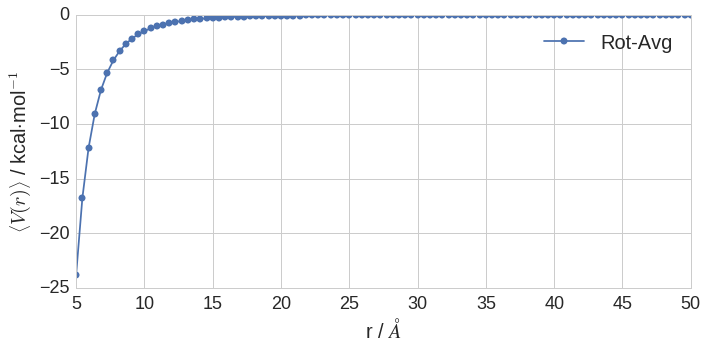

In [5]:
#Theory: a rotationally-averaged charge-dipole potential
#Function form : psi(r) = -1/3kBT  (qmu/4pi*eps0)* (1/r^4)
val_r = linspace(5,50,100) #vector r - start from 5 since around 0 we have astronomical values
thpot = [] #list of values for theory
q1, mu, epsw = 1, (2.35*0.20819434), 82.0 #  charge q1 = 1e , dipole mu = 0.47 eA, dielectric TIP3P water epsw = 82.0
one_over_four_pi_eps0 = 332.14711959 # kcal Ang/(mol e^2)
#parameters
invkT3 = -1/(3*(0.0019872041*298.0)) #the inverse -1/3KT
#cycle and store the values
for r in val_r:
    qdip =  (one_over_four_pi_eps0)*(q1*mu)
    qkt = (invkT3*qdip**2)*(1/r**4)
    thpot.append(qkt)

#plot
color = sbn.color_palette() #define colors from seaborn
#####################################
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(val_r, thpot,color=color[0],marker="o",label="Rot-Avg")
ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.legend(loc="best",fontsize=20)
ax.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20)
plt.tight_layout()
#plt.savefig("charge-dipole_RF.png",transparent=True,dpi=300)

 

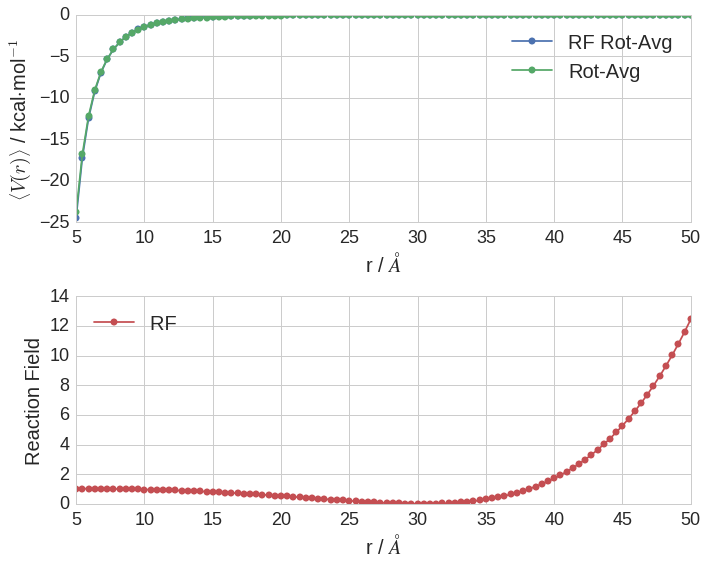

In [6]:
#Rotationally-averaged charge-dipole potential in a reaction field
#Functional form:
#(-4/3*kT)*(qu/4pieps0*r**2)**2 * ( (esp1 + esp2)**2 + (r**3/a**3)*eps1*(eps1*(r**3/a**3 - 2) - 2*eps2) ) 
val_r = linspace(5,50,100) #vector r
avgpot = [] #list of values for the average potential
rfield = [] #reaction field part of the potential
q1, mu, epsw = 1, (2.35*0.20819434), 82.0 #  charge q1 = 1e , dipole mu = 0.47 eA, dielectric TIP3P water epsw = 82.0
one_over_four_pi_eps0 = 332.14711959 # kcal/mol e^2
#parameters
invkT3 = -1/(3*(0.0019872041*298.0)) #kB = 0.0019872041 kcal/(mol K)
rc = 30 #cutoff at 30 Angstrom
#terms with the espw
eps1 = ( epsw - 1)/(1 + 2*epsw)
eps2 = 3/(1+2*epsw)
epssq = (eps1 + eps2)**2
#cycle and store the values
for r in val_r:
    #charge term
    charge =  (one_over_four_pi_eps0)*(q1*mu)
    #coupled with boltzmann term and distance r**-4
    boltz = invkT3*(charge**2)*(r**-4)
    #reaction field terms
    radii = (r**3/rc**3) #ratio between r and cutoff
    react = radii*eps1*(eps1*(radii-2)-2*eps2) #(r**3/a**3)*eps1*(eps1*(r**3/a**3 - 2) - 2*eps2)
    total = boltz*4*(epssq + react)
    avgpot.append(total)
    rfield.append(4*(epssq+react))



 
#plot
fig, axarr = plt.subplots(2, 1,figsize=(10,8))
axarr[0].plot(val_r, avgpot,color=color[0],marker="o",label="RF Rot-Avg") # ion-dipole reaction field
axarr[0].plot(val_r, thpot,color=color[1],marker="o",label="Rot-Avg")     # theory rotationally averaged
#axarr[0].plot(val_r, rfield,color=color[2],marker="o",label="RF ")        # reaction field contribution
axarr[0].set_xlabel("r / $\AA$",fontsize=20)
axarr[0].tick_params(labelsize=18)
axarr[0].legend(loc="best",fontsize=20)
axarr[0].set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20)
#axarr[0].set_ylim(-5,1)

axarr[1].plot(val_r, rfield,color=color[2],marker="o",label="RF ")        # reaction field contribution
axarr[1].set_xlabel("r / $\AA$",fontsize=20)
axarr[1].tick_params(labelsize=18)
axarr[1].legend(loc="best",fontsize=20)
axarr[1].set_ylabel(r"Reaction Field" ,fontsize=20)

fig.tight_layout()
#Eventually  avgpot values after the cutoff are about 10**-5
#plt.tight_layout()

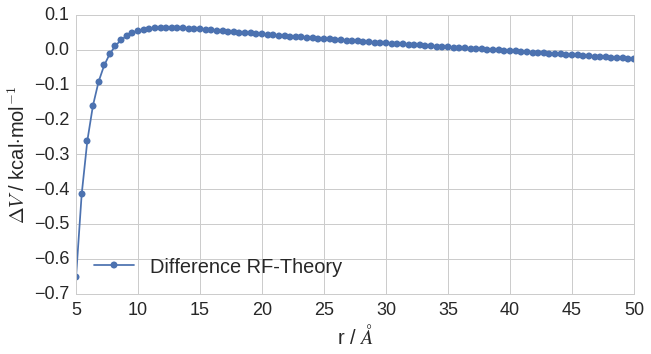

In [7]:
#Difference between theory and reaction field charge-dipole interaction (rot avg)
diff = []
for x,val in enumerate(avgpot,0):
    res = val - thpot[x]
    diff.append(res)

color = sbn.color_palette()
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(val_r, diff,color=color[0],marker="o",label="Difference RF-Theory")
ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.legend(loc="best",fontsize=20)
ax.set_ylabel(r"$\Delta V$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20)

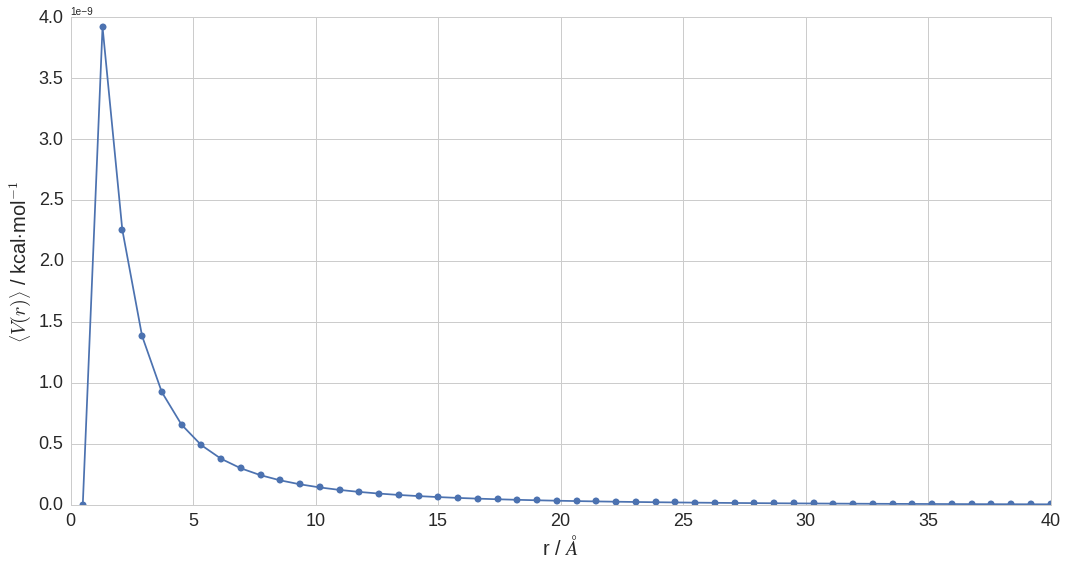

In [8]:
#ideal dipole test: simulation from 0 to 40 angstrom in 100 of points
#here I have simulated an ideal dipole interacting with a charge (+1 Na+) in a reaction field with 30 A cutoff
#to explore all teh possible orientations I have adopted a rotation matrix approach, creating 1'500'000 possible 
#orientations
#plot
results = open("sire_test/ideal_dipole/simulations/results.dat","r") #inputfiles: distance(r) potential  std deviation
potential = [] #list for potential
distance = [] #list for position
stddev = []
#cycle and store
for line in results.readlines():
    
    pot  = float(line.split(",")[1]) 
    r = float(line.split(",")[0])
    err = float(line.split(",")[2])
    potential.append(pot)
    distance.append(r)
    stddev.append(err)

#plot
color = sbn.color_palette()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(distance, potential,color=color[0],marker="o",label="RF ion-dipole ")

ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
#ax.set_xlim(0,30)
plt.tight_layout()
#plt.savefig("charge-dipole_SIM.png",transparent=True,dpi=300)

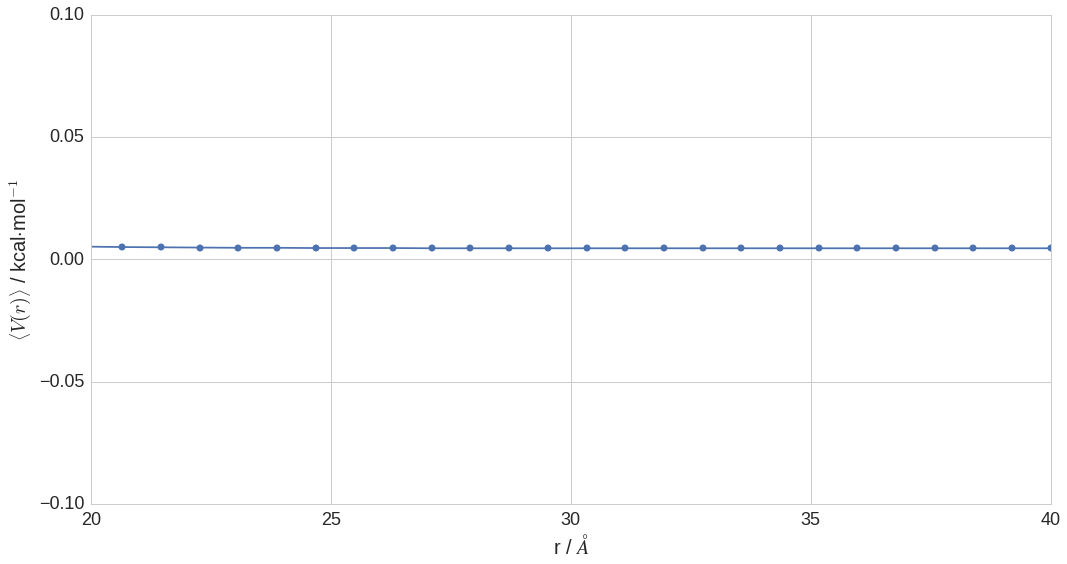

In [13]:
#TIP3P water vs ion: from 0 to 40 angstrom in 50 points
#here I computed the Barker Watter reaction field potential energy between a rotating tip3p water and an Na+ ion
#the number of rotatino was the same as in the dipole experiment
wat_file = open("sire_test/water/simulations/results.dat","r") #inputfiles with potential and positions
water_pot = [] #list for potential
distance = [] #list for position
water_err = []
#cycle and store
for line in wat_file.readlines():
    pot  = float(line.split(",")[1]) 
    r = float(line.split(",")[0])
    err = float(line.split(",")[2])
    water_pot.append(pot)
    distance.append(r)
    water_err.append(err)
    
#plot
color = sbn.color_palette()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(distance, water_pot,color=color[0],marker="o",label="RF ion-TIP3P")
ax.set_xlim(20,40)
ax.set_ylim(-0.1,0.1)
ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 

plt.tight_layout()


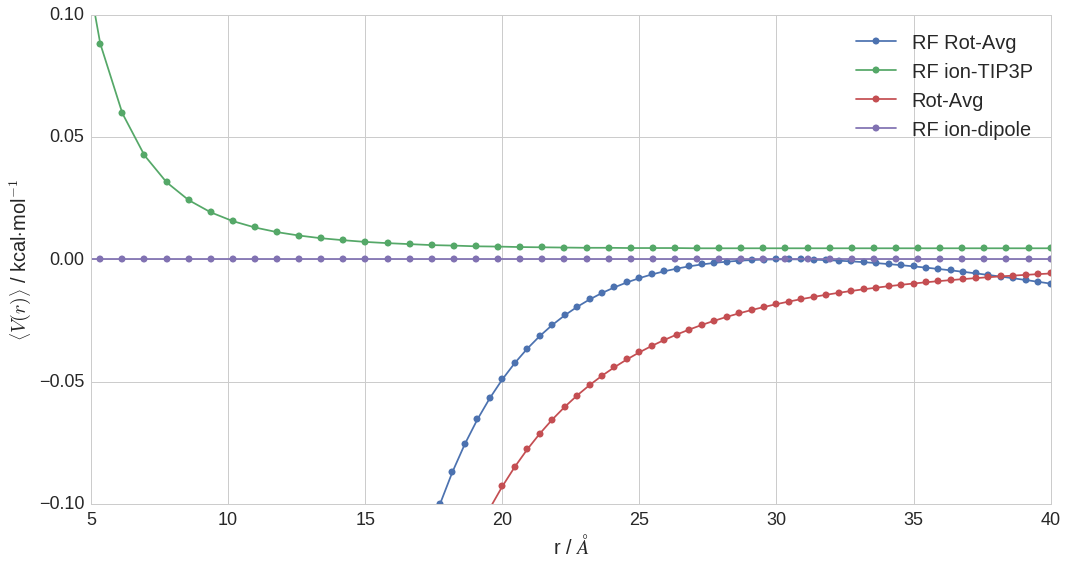

In [16]:
#Comparison between RF rot-avg ion-dipole and  RF ion-TIP3P  
color = sbn.color_palette()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(val_r, avgpot,color=color[0],marker="o",label="RF Rot-Avg")
ax.plot(distance, water_pot,color=color[1],marker="o",label="RF ion-TIP3P")
ax.plot(val_r, thpot,color=color[2],marker="o",label="Rot-Avg")
ax.plot(distance,potential,color=color[3],marker="o",label="RF ion-dipole")

ax.set_xlabel("r / $\AA$",fontsize=20)
ax.tick_params(labelsize=18)
ax.legend(loc="best",fontsize=20)
ax.set_ylabel(r"$\left \langle V(r) \right \rangle$ / kcal$\cdot$mol$^{-1}$" ,fontsize=20) 
ax.set_xlim(5,40)
ax.set_ylim(-0.1,0.1)
plt.tight_layout()



In [15]:
#now try to merge all the functions we have
